<a href="https://colab.research.google.com/github/vedith12/ML-tasks/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#installing dependencies
!pip install -q imbalanced-learn scikit-learn matplotlib seaborn

In [35]:
#all imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import warnings
warnings.filterwarnings('ignore')


In [36]:
#loading dataset
DATA_PATH = "/content/malware.csv"
TARGET_COLUMN = "classification"

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()

df.columns


Dataset shape: (100000, 35)


Index(['hash', 'millisecond', 'classification', 'state', 'usage_counter',
       'prio', 'static_prio', 'normal_prio', 'policy', 'vm_pgoff',
       'vm_truncate_count', 'task_size', 'cached_hole_size', 'free_area_cache',
       'mm_users', 'map_count', 'hiwater_rss', 'total_vm', 'shared_vm',
       'exec_vm', 'reserved_vm', 'nr_ptes', 'end_data', 'last_interval',
       'nvcsw', 'nivcsw', 'min_flt', 'maj_flt', 'fs_excl_counter', 'lock',
       'utime', 'stime', 'gtime', 'cgtime', 'signal_nvcsw'],
      dtype='object')

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# FIXED CONFIGURATION
DATA_PATH = "/content/malware.csv"
TARGET_COLUMN = "classification"

# Load dataset
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
print("Columns:", list(df.columns))

# Handling non useful columns
# Remove 'hash' column if it exists (unique identifier)
if 'hash' in df.columns:
    df = df.drop('hash', axis=1)
    print("Removed 'hash' column")

# Split features and target
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# Handling categorical targets
if not pd.api.types.is_numeric_dtype(y):
    print("Encoding categorical target...")
    le = LabelEncoder()
    y = le.fit_transform(y)
    print("Label encoding mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

# Check class distribution
print("Target distribution:")
target_counts = pd.Series(y).value_counts()
print(target_counts)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Smart SMOTE application
imbalance_ratio = target_counts.max() / target_counts.min()
print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2.0:  # it will only apply if significantly imbalanced
    print("Applying SMOTE...")
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print("SMOTE applied!")
else:
    print("Dataset is balanced, skipping SMOTE")

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Dataset shape: (100000, 35)
Columns: ['hash', 'millisecond', 'classification', 'state', 'usage_counter', 'prio', 'static_prio', 'normal_prio', 'policy', 'vm_pgoff', 'vm_truncate_count', 'task_size', 'cached_hole_size', 'free_area_cache', 'mm_users', 'map_count', 'hiwater_rss', 'total_vm', 'shared_vm', 'exec_vm', 'reserved_vm', 'nr_ptes', 'end_data', 'last_interval', 'nvcsw', 'nivcsw', 'min_flt', 'maj_flt', 'fs_excl_counter', 'lock', 'utime', 'stime', 'gtime', 'cgtime', 'signal_nvcsw']
Removed 'hash' column
Encoding categorical target...
Label encoding mapping: {'benign': 0, 'malware': 1}
Target distribution:
1    50000
0    50000
Name: count, dtype: int64
Class imbalance ratio: 1.00:1
Dataset is balanced, skipping SMOTE
Train size: (80000, 33) Test size: (20000, 33)


In [39]:
# Scaling + PCA + LDA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA (keep 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# LDA (max = n_classes - 1)
n_classes = len(np.unique(y))
lda = LDA(n_components=min(n_classes-1, 2))
X_train_lda = lda.fit_transform(X_train_pca, y_train)
X_test_lda = lda.transform(X_test_pca)

print("Original shape:", X_train.shape)
print("After PCA:", X_train_pca.shape)
print("After LDA:", X_train_lda.shape)


Original shape: (80000, 33)
After PCA: (80000, 12)
After LDA: (80000, 1)


In [44]:
def evaluate_rf_colab(X_train, X_test, y_train, y_test, model_name="Random Forest"):
    print(f"\n=== {model_name} Evaluation ===")

    # Default RF for comparison
    rf_default = RandomForestClassifier(random_state=42)
    rf_default.fit(X_train, y_train)
    y_pred_default = rf_default.predict(X_test)
    acc_default = accuracy_score(y_test, y_pred_default)

    # Tuned RF via hyperparameter tuning
    rf_tuned = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    rf_tuned.fit(X_train, y_train)
    y_pred_tuned = rf_tuned.predict(X_test)
    y_pred_proba = rf_tuned.predict_proba(X_test)[:,1] if len(np.unique(y_train))==2 else None
    acc_tuned = accuracy_score(y_test, y_pred_tuned)

    print(f"Default RF Accuracy: {acc_default:.4f}")
    print(f"Tuned RF Accuracy:   {acc_tuned:.4f}  ← Improvement via hyperparameter tuning")

    # Classification report
    print("\nClassification Report (Tuned):")
    print(classification_report(y_test, y_pred_tuned))

    # Cross-validation
    cv_scores = cross_val_score(rf_tuned, X_train, y_train, cv=5)
    print(f"5-Fold CV Accuracy (Tuned): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Feature importance
    importance = pd.DataFrame({
        'Feature': [f'LDA_Component_{i+1}' for i in range(X_train.shape[1])],
        'Importance': rf_tuned.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Visualizations

    plt.figure(figsize=(12,5))

    # Accuracy Comparison
    plt.subplot(1,2,1)
    plt.bar(['Default RF','Tuned RF'], [acc_default, acc_tuned], color=['gray','skyblue'])
    plt.ylim(0,1)
    plt.title("Default vs Tuned RF Accuracy")
    for i,v in enumerate([acc_default, acc_tuned]):
        plt.text(i, v+0.01, f"{v:.4f}", ha='center', fontweight='bold')

    # ROC Curve (binary)
    plt.subplot(1,2,2)
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'Tuned RF (AUC={auc_score:.4f})')
        plt.plot([0,1],[0,1],'--', color='red')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
    else:
        plt.text(0.5,0.5,'ROC N/A for Multi-class', ha='center', va='center')

    plt.tight_layout()
    plt.show()

    return rf_tuned, importance, acc_tuned, cv_scores



=== Random Forest Evaluation ===
Default RF Accuracy: 0.8084
Tuned RF Accuracy:   0.8601  ← Improvement via hyperparameter tuning

Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     10000
           1       0.87      0.85      0.86     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

5-Fold CV Accuracy (Tuned): 0.8585 ± 0.0018


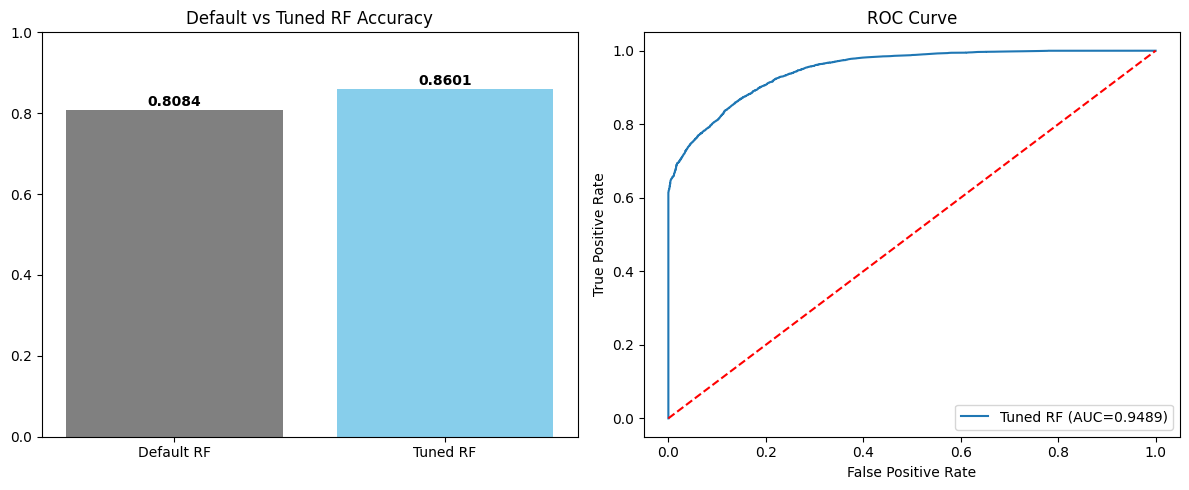

In [41]:
rf_model, feature_imp, accuracy, cv = evaluate_rf_colab(X_train_lda, X_test_lda, y_train, y_test)

<Figure size 600x600 with 0 Axes>

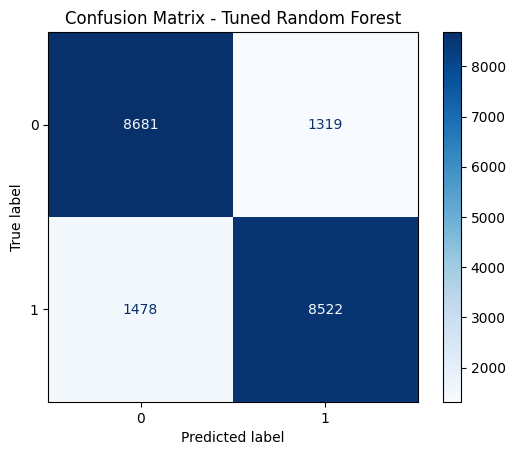

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_tuned = rf_model.predict(X_test_lda)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()




---

